<a href="https://colab.research.google.com/github/eli-vigneron/Deep-Learning-Pytorch/blob/main/SGD_distribution_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal**<br>
The goal of this is to train a ResNet18 model on MNIST and to track throughout the epochs of SGD the distribution of the margins.

Denote by $f_{i,c} \in \mathbb{R}^C$ the logits of the $i$-th training example in the $c$-th class. Denote further by $f_{i,c,c'} \in \mathbb{R}$ the $c'$-th logit. The margin is defined to be $f_{i,c,c} - f_{i,c,c'}$ (for $c \neq c'$).

*Requires including a GPU*


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

%matplotlib inline

In [ ]:
# hyperparameters
device          = "cuda"
lr              = 0.0679
batch_size      = 128
momentum        = 0.9
weight_decay    = 5e-4

epochs          = 32
list_epochs     = [1,2,4,8,16,32]

In [ ]:
# deep network
model = models.resnet18(pretrained=False, num_classes=10)

model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False) 
model.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, 
                             ceil_mode=False)

model = model.to(device)

# dataset loaders
transform = transforms.Compose([transforms.Pad(2),
                                transforms.ToTensor(),
                                transforms.Normalize(0.1307,0.3081)])

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', download=True, train=True, transform=transform), 
    batch_size=batch_size, shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', download=True, train=False, transform=transform),
    batch_size=batch_size, shuffle=False, drop_last=False)

# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

epochs_lr_decay = [epochs//2, epochs*3//4]
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                              milestones=epochs_lr_decay,
                                              gamma=0.1)



Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Streaming output truncated to the last 5000 lines.
Train		Epoch: 22 	Batch 160/468 (34%) 	Batch Loss: 0.004611 	Batch Accuracy: 99.995117
Train		Epoch: 22 	Batch 161/468 (34%) 	Batch Loss: 0.002448 	Batch Accuracy: 99.995148
Train		Epoch: 22 	Batch 162/468 (35%) 	Batch Loss: 0.003005 	Batch Accuracy: 99.995177
Train		Epoch: 22 	Batch 163/468 (35%) 	Batch Loss: 0.002990 	Batch Accuracy: 99.995207
Train		Epoch: 22 	Batch 164/468 (35%) 	Batch Loss: 0.002568 	Batch Accuracy: 99.995236
Train		Epoch: 22 	Batch 165/468 (35%) 	Batch Loss: 0.001909 	Batch Accuracy: 99.995265
Train		Epoch: 22 	Batch 166/468 (35%) 	Batch Loss: 0.001698 	Batch Accuracy: 99.995294
Train		Epoch: 22 	Batch 167/468 (36%) 	Batch Loss: 0.001581 	Batch Accuracy: 99.995322
Train		Epoch: 22 	Batch 168/468 (36%) 	Batch Loss: 0.002590 	Batch Accuracy: 99.995350
Train		Epoch: 22 	Batch 169/468 (36%) 	Batch Loss: 0.003900 	Batch Accuracy: 99.995377
Train		Epoch: 22 	Batch 170/468 (36%) 	Batch Loss: 0.002385 	Batch Accuracy: 99

Text(0.5, 1.0, 'Distribution of Margins')

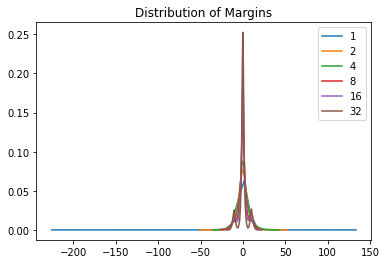

In [ ]:
train_accuracy = []
test_accuracy = []

# iterate over epochs
for epoch in range(1, epochs+1):
    # train phase
    model.train()
    accuracy = 0
    N = 0

    all_margins = []

    # iterate over train data
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        logits = model(images)
        loss = loss_function(logits, labels)

        for c in labels:
            for j, logit in enumerate(logits[c]):
                if c != j:
                    all_margins.append(float(logits[c][c]-logit)) 
    
 
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(logits,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

        print('Train\t\tEpoch: {} \t'
              'Batch {}/{} ({:.0f}%) \t'
              'Batch Loss: {:.6f} \t'
              'Batch Accuracy: {:.6f}'.format(
                  epoch,
                  batch_idx,
                  len(train_loader),
                  100. * batch_idx / len(train_loader),
                  loss.item(),
                  100. * accuracy/N))
    train_accuracy.append(100. * accuracy/N)

    # TASK 2: ADD CODE HERE
    lr_scheduler.step()

    if epoch in list_epochs:
        hist, bins_edges = np.histogram(all_margins, bins=50, density=True)
        bin_centers = 0.5*(bins_edges[1:]+bins_edges[:-1])
        plt.plot(bin_centers, hist, label=str(epoch))

    # test phase
    model.eval()
    accuracy = 0
    N = 0

    # iterate over test data
    for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        logits = model(images)
        
        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(logits,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

    test_accuracy.append(100. * accuracy/N)
    print('Test accuracy:', test_accuracy[-1])

# plot results
plt.legend()
plt.title('Distribution of Margins')